In [103]:
%reload_ext autoreload
%autoreload 1
from classes.helper_functions import HelperFuncs

h = HelperFuncs()

constructor of HelperFuncs


,Text,sentiment
0,What transformed that night from happy into n...,1
1,Start Early in Your Planning You ll want to de...,0
2,Have you ever spoken to Donald or does he ign...,1
3,Do you have style story idea or tip,1
4,I think blogs are changing the way information...,1
5,For now we ll dream of warm days ahead when we...,1
6,That was expected,0
7,They expected breathtaking encounters griping ...,0
8,The top receiver from last year will not be a...,0
9,Zoosk iOs and Android Zoosk is top mobile dati...,1


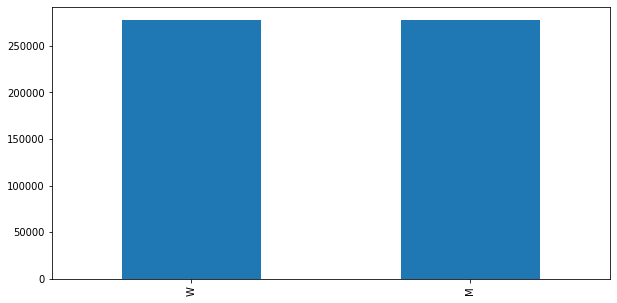

In [104]:
import pandas as pd

df = pd.read_json('../datasets/8_dataset_simple.json')
df = df[df.Text != " "]

M, W = df["Gender"].value_counts()
if M>W:
    diff = M-W
    df = df.drop(df.loc[df['Gender'] == 'M'].index[:diff], axis=0)
elif W>M:
    diff = W-M
    df = df.drop(df.loc[df['Gender'] == 'W'].index[:diff], axis=0)

df["Gender"].value_counts().plot(kind="bar", figsize=(10,5))
df['sentiment'] = df.Gender.apply(lambda x: 0 if x == "M" else 1)
df = df.drop('Gender', axis=1)
df = df.sample(frac=1).reset_index(drop=True)

split = round(len(df)*0.75)
train_data = df[:split]
test_data = df[split:]

train_data.head(10)

In [105]:
import os
import time
import tensorflow as tf
from keras import callbacks

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

model_name = 'entire_sentences'
model_variant = '1_dropout_w_2_relu'

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        exp = lr0 * 0.1**(epoch / s)
        tf.summary.scalar('learning rate', data=exp, step=epoch)
        return exp
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=10)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir()
file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
file_writer.set_as_default()

tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

mcp_save = callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

my_callbacks = [earlystopping, lr_scheduler, tensorboard_cb]

In [106]:
# Borrowed from: https://towardsdatascience.com/a-complete-step-by-step-tutorial-on-sentiment-analysis-in-keras-and-tensorflow-ea420cc8913f

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks
import tensorflow as tf
import numpy as np

vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data['Text'])

train_seqs = tokenizer.texts_to_sequences(train_data['Text'])
X_train = pad_sequences(train_seqs, maxlen=max_length, truncating=trunc_type)
test_seqs = tokenizer.texts_to_sequences(test_data['Text'])
X_test = pad_sequences(test_seqs, maxlen=max_length)

y_train = np.array(train_data['sentiment'])
y_test = np.array(test_data['sentiment'])

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3, noise_shape=None, seed=None),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2, noise_shape=None, seed=None),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# model_name = 'entire_sentences'
# model_variant = 'base'
# tensorboard_cb = callbacks.TensorBoard(h.get_run_logdir('logged_models/' + model_name + '/' + model_variant))

# history = model.fit(X_train, y_train, epochs=20, callbacks =[h.earlystopping, h.lr_scheduler, tensorboard_cb], validation_split=0.2)
history = model.fit(X_train, y_train, epochs=50, callbacks =my_callbacks, validation_split=0.2)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 120, 16)           640000    
_________________________________________________________________
global_average_pooling1d_15  (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)               

<Figure size 432x288 with 0 Axes>

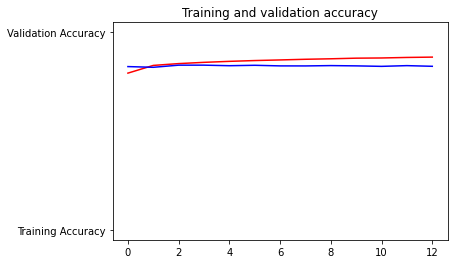

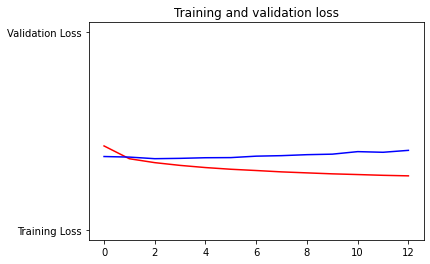

<Figure size 432x288 with 0 Axes>

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

In [108]:
model.save('classifiers/' + model_name + '/' + model_variant + '.h5')

In [109]:
y_pred = model.predict(X_test)
y_pred_binary = []
for x in y_pred:
    y_pred_binary.append(0 if x < 0.5 else 1)

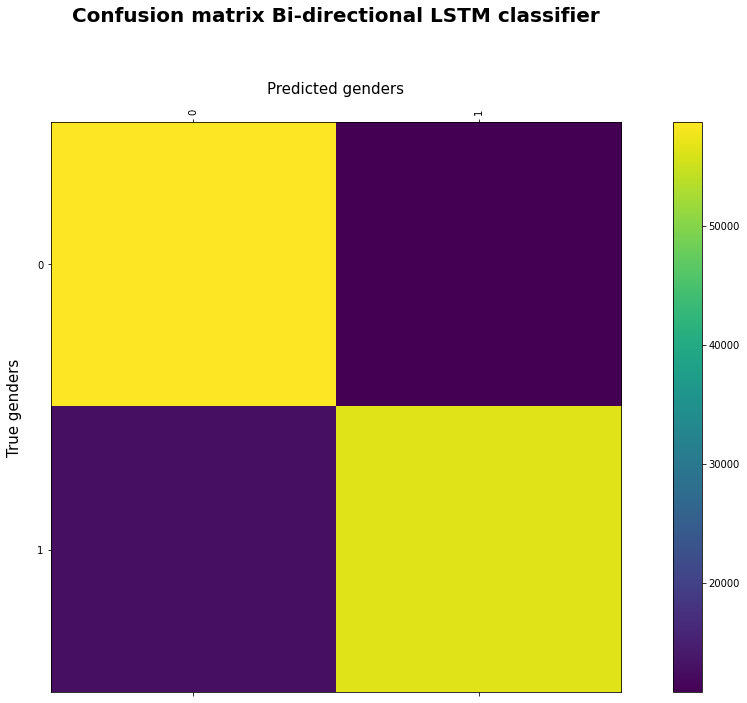

array([[58740, 10797],
       [12827, 56452]], dtype=int64)

In [110]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_binary)

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted genders', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True genders', fontsize = 15, labelpad=15.0)
ax.set_title('Confusion matrix Bi-directional LSTM classifier',fontweight="bold", size=20, pad=100.0)

fig.colorbar(cax)
plt.xticks(range(2), [0,1], rotation=90)
plt.yticks(range(2), [0,1])
plt.show()
cm

In [111]:
from sklearn.metrics import classification_report
sentiment_vocab = ['M', 'W']

report = classification_report(y_test, y_pred_binary, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:2]
df_perf_2.insert(loc=0, column='Gender', value=sentiment_vocab)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\hanse\AppData\Local\Temp/ipykernel_5816/1509086957.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)


,Gender,precision,recall,f1-score,support
0,M,0.82,0.84,0.83,69537.0
1,W,0.84,0.81,0.83,69279.0
